In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

sys.path.append('../')
from model import Model
from image_generation import generate_block
from scipy import signal, ndimage
from copy import deepcopy
from utils import extract_window

from scipy import signal, ndimage, interpolate
from functools import partial
import cProfile
from pathlib import Path

cmap='plasma'
np.set_printoptions(precision=3)

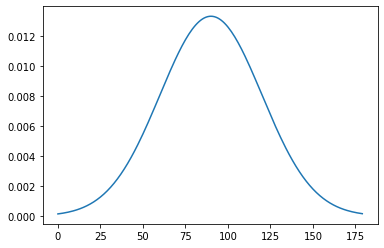

In [12]:
sigma = 30
mu = 90
x = np.arange(0, 180)
hg = np.exp(-((x-mu) ** 2) / (2 * sigma ** 2))
plt.plot(x, hg / np.sum(hg))

Initialized model with 3 features.
V1 has dims (121, 121)
V2 has dims (60, 60)
V4 has dims (15, 15)


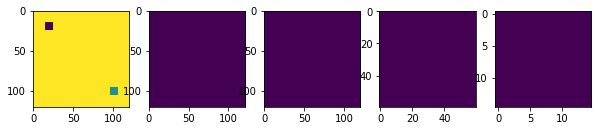

In [54]:
parm_df = pd.read_csv("../parameters.csv", index_col=0)
model = Model(parm_df, features=[30, 60, 90])
# na = generate_block(figure_orientation=45, bg_orientation=135)
na = generate_block()
na = np.full_like(na, 90)
na[15:25, 15:25] = 30
na[96:106, 96:106] = 60

fig, axs = plt.subplots(1,5, figsize=(10,10))
LGN = {}
V1 = {}
V2 = {}
V4 = {}
# for f in range(len(model.features)):
#     # Each dictionary value should be a list of results where a result is a numpy array
#     LGN[f] = [deepcopy(model.LGN[f].V)]
#     V1[f] = [deepcopy(model.V1[f].V)]
#     V2[f] = [deepcopy(model.V2[f].V)]
#     V4[f] = [deepcopy(model.V4[f].V)]

LGN["mean"] = [np.mean( np.array([ model.LGN[f].V for f in range(len(model.features))]), axis=0 )]
V1["mean"] = [np.mean( np.array([ model.V1[f].V for f in range(len(model.features))]), axis=0 )]
V2["mean"] = [np.mean( np.array([ model.V2[f].V for f in range(len(model.features))]), axis=0 )]
V4["mean"] = [np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 )]

# LGN["sum"] = [np.sum( np.array([ model.LGN[f].V for f in range(len(model.features))]), axis=0 )]
# V1["sum"] = [np.sum( np.array([ model.V1[f].V for f in range(len(model.features))]), axis=0 )]
# V2["sum"] = [np.sum( np.array([ model.V2[f].V for f in range(len(model.features))]), axis=0 )]
# V4["sum"] = [np.sum( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 )]

# axs[0,0].imshow(LGN[0][0])
# axs[0,1].imshow(V1[0][0])
# axs[0,2].imshow(V2[0][0])
# axs[0,3].imshow(V4[0][0])
# axs[1,0].imshow(LGN[1][0])
# axs[1,1].imshow(V1[1][0])
# axs[1,2].imshow(V2[1][0])
# axs[1,3].imshow(V4[1][0])
axs[0].imshow(na)
axs[1].imshow(LGN["mean"][0])
axs[2].imshow(V1["mean"][0])
axs[3].imshow(V2["mean"][0])
axs[4].imshow(V4["mean"][0])
fig.tight_layout = True
# print(model.parameters["V4"]["plus_supp"])
# plt.imshow(na)

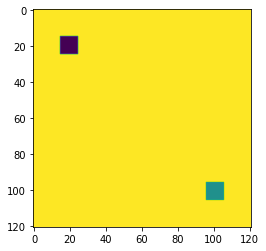

In [55]:
plt.imshow(na)

In [56]:
n = 600
empty = np.zeros_like(na)
for i in range(n):
    if 40 < i:
        model.update(na, 10e-3)
    else:
        model.update(empty, 10e-3)
    V1["mean"].append(np.mean( np.array([ model.V1[f].V for f in range(len(model.features))]), axis=0 ))
    V4["mean"].append(np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 ))


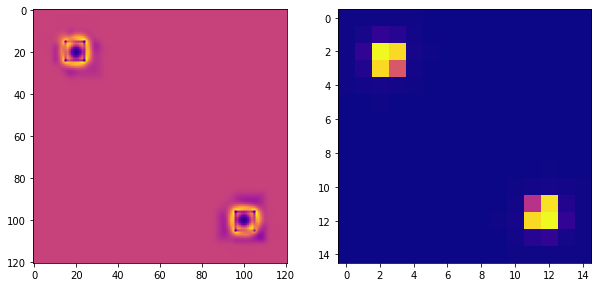

In [57]:
cmap = 'plasma'
n=50

f, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(V1["mean"][n], cmap=cmap)
axs[1].imshow(V4["mean"][n], cmap=cmap)


In [37]:
def norm(x):
#     print(np.max(x))
    return x / np.max(x)
#     return (x-np.min(x)) / (np.max(x) - np.min(x))



def extract_portions(activity, x_min, x_max, y_min, y_max):
    if y_min == y_max:
        center = activity[:,x_min:x_max,y_min]
    else:
        center = activity[:,x_min:x_max,y_min:y_max]
    
    bg1 = activity[:,:x_min,:]
    bg2 = activity[:,x_max:,:]
    bg3 = activity[:,x_min:x_max,:y_min]
    bg4 = activity[:,x_min:x_max,y_max:]
    background = [bg1,bg2,bg3,bg4]
    
    if y_min == y_max:
        edge1 = activity[:,x_min-1:x_min,y_min]
        edge2 = activity[:,x_max:x_max+1,y_min]
        edge3 = activity[:,x_min:x_max,y_min]
        edge4 = activity[:,x_min:x_max,y_max]
    else:
        edge1 = activity[:,x_min-1:x_min,y_min:y_max]
        edge2 = activity[:,x_max:x_max+1,y_min:y_max]
        edge3 = activity[:,x_min:x_max,y_min-1:y_min]
        edge4 = activity[:,x_min:x_max,y_max-1:y_max]
    
    edges = [edge1, edge2, edge3, edge4]
    return center, background, edges
    

In [46]:
center_60_1, background_60_1, _ = extract_portions(V4_arr, 2, 3, 3, 3)
center_30_1, background_30_1, _ = extract_portions(V4_arr, 12, 13, 13, 13)

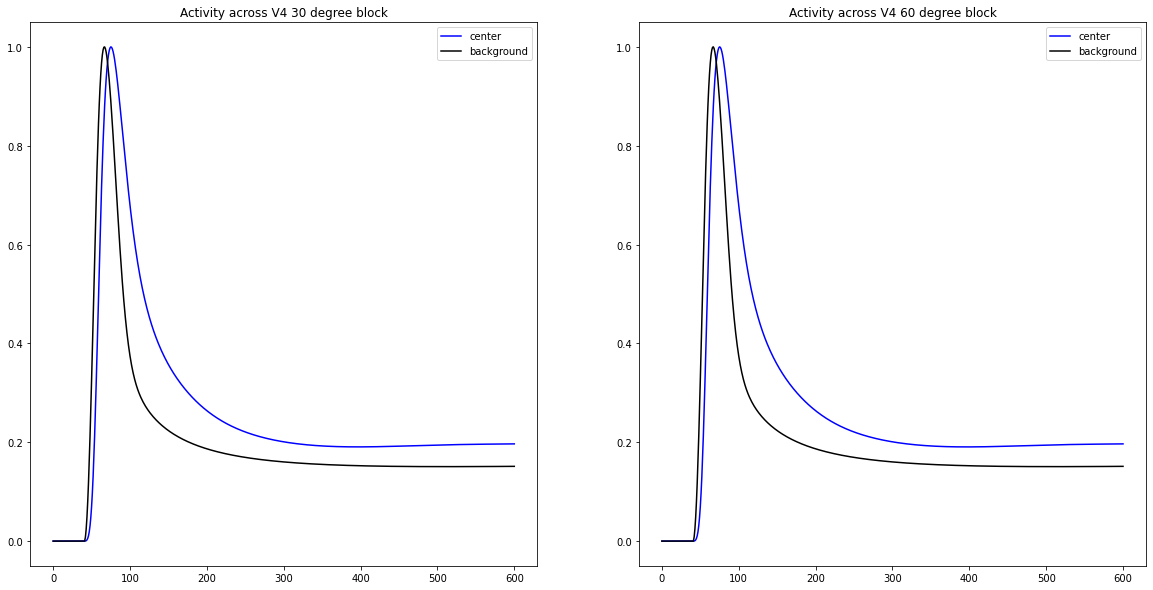

In [58]:
_V1 = {}
_V2={}
_V4={}
# version = 6
# for f in range(len(model.features)):
#     preprocessing[f] = np.load(f"results{version}/preprocessing_{f}.npy")
#     _V1[f] = np.load(f"results{version}/V1_{f}.npy")
#     _V2[f] = np.load(f"results{version}/V2_{f}.npy")
#     _V4[f] = np.load(f"results{version}/V4_{f}.npy")

version = "1_0"
# preprocessing["mean"] = np.load(f"results{version}/preprocessing_mean.npy")
_V1["mean"] = np.load(f"results{version}/V1_mean.npy")
_V2["mean"] = np.load(f"results{version}/V2_mean.npy")
_V4["mean"] = np.load(f"results{version}/V4_mean.npy")
# preprocessing["sum"] = np.load(f"results{version}/preprocessing_sum.npy")
# _V1["sum"] = np.load(f"results{version}/V1_sum.npy")
# _V2["sum"] = np.load(f"results{version}/V2_sum.npy")
# _V4["sum"] = np.load(f"results{version}/V4_sum.npy")


f, axs = plt.subplots(1,2, figsize=(20,10))

V1_arr = np.array(V1["mean"])

# na[15:25, 15:17] = 60
# na[96:106, 102:104] = 30
# center, background, edges = extract_portions(V1_arr, 48, 72, 48, 72)
center, background, edges = extract_portions(V1_arr, 96,106, 102,104)
V1max = np.max(V1_arr)
# axs[0].imshow(center[600])
center_mean = np.mean(center, axis=(1,2))
bg_mean = np.mean([np.mean(V1_arr, axis=(1,2)) for bg in background], axis=0)
edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

# axs[0].plot((center_mean / V1max), 'b', label='center')
# axs[0].plot((bg_mean / V1max), 'k', label='background')
# axs[0].plot((edge_mean / V1max), 'r', label='edge')
# axs[0].legend()
# axs[0].title.set_text("Activity across V1")

V4_arr = np.array(V4["mean"])

# center, background, edges = extract_portions(V4_arr, 6, 9, 6, 9)
center, background, edges = extract_portions(V4_arr, 2, 3, 2, 3)
# print(V4_arr[:,2:3,2])
center_mean = np.mean(center, axis=(1))
bg_mean = np.mean([np.mean(V1_arr, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

V4max = np.max(V4_arr)

axs[1].plot(norm(center_mean), 'b', label='center')
axs[1].plot(norm(bg_mean), 'k', label='background')
# axs[1].plot((edge_mean / V4max), 'r', label='edge')
axs[1].legend()
axs[1].title.set_text("Activity across V4 60 degree block")


center, background, edges = extract_portions(V4_arr, 12, 13, 12, 13)
# print(V4_arr[:,2:3,2])
center_mean = np.mean(center, axis=(1))
bg_mean = np.mean([np.mean(V1_arr, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

V4max = np.max(V4_arr)

axs[0].plot(norm(center_mean), 'b', label='center')
axs[0].plot(norm(bg_mean), 'k', label='background')
# axs[1].plot((edge_mean / V4max), 'r', label='edge')
axs[0].legend()
axs[0].title.set_text("Activity across V4 30 degree block")


# V1_arr = np.array(_V1["sum"])

# center, background, edges = extract_portions(V1_arr, 48, 72, 48, 72)

# center_mean = np.mean(center, axis=(1,2))
# bg_mean = np.sum([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.sum([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)

# axs[1,0].plot(norm(center_mean), 'b', label='center')
# axs[1,0].plot(norm(bg_mean), 'k', label='background')
# axs[1,0].plot(norm(edge_mean), 'r', label='edge')
# axs[1,0].legend()


# V4_arr = norm(np.array(_V4["sum"]))
# center, background, edges = extract_portions(V4_arr, 6, 9, 6, 9)
# center_mean = np.mean(center, axis=(1,2))
# bg_mean = np.mean([np.mean(bg, axis=(1,2)) for bg in background], axis=0)
# edge_mean = np.mean([np.mean(edge, axis=(1,2)) for edge in edges], axis=0)


# axs[1,1].plot(norm(center_mean), 'b', label='center')
# axs[1,1].plot(norm(bg_mean), 'k', label='background')
# axs[1,1].plot(norm(edge_mean), 'r', label='edge')
# axs[1,1].legend()

In [49]:
center_60_2, background_60_2, _ = extract_portions(V4_arr, 2, 3, 3, 3)
center_30_2, background_30_2, _ = extract_portions(V4_arr, 12, 13, 13, 13)

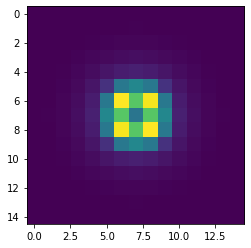

In [26]:
plt.imshow(np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 ))

In [66]:
import math
na = generate_block()

Stimulus = np.tile(0,[121, 121, 2])
Stimulus[:,:,0] = na
Stimulus[:,:,1] = 1-na

StimulusSeq = np.zeros((121, 121, 2, 2))
StimulusSeq[:,:,:,0] = Stimulus
StimulusSeq[:,:,:,1] = np.zeros((121, 121, 2))
IndexSeq = np.tile(2,[1,40]) #...
#             repmat(1,1,stimulusIterNum) ...
#             repmat(2,1,postIterNum)];
IndexSeq

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [25]:
mean_activity_v1 = model.V1_trace
mean_activity_v4 = np.array(model.V4_trace)[:,:2]
print(mean_activity_v4.shape)
maxV1 = np.max(mean_activity_v1)
maxV4 = np.max(mean_activity_v4)
mean_activity_v1 /= maxV1
mean_activity_v4 /= maxV4
# mean_activity_v4[:,0] /= np.max(mean_activity_v4[:,0])
# mean_activity_v4[:,1] /= np.max(mean_activity_v4[:,1])

slice_activity_v1 = model.V1_slice / maxV1
slice_activity_v4 = model.V4_slice / maxV4

offsetRfV1 = int(model.V1[0].input_dim / 6)
offsetRfV4 = int(model.V4[0].input_dim / 6)

rfLen = 1;

plt.plot(mean_activity_v4, label=['background', 'center'])
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [18]:
version = "small_diff"

Path(f"results{version}").mkdir(parents=True, exist_ok=True)
# for f in model.features:
#     np.save(f"results{version}/preprocessing_{f}.npy", preprocessing[f])
#     np.save(f"results{version}/V1_{f}.npy", V1[f])
#     np.save(f"results{version}/V2_{f}.npy", V2[f])
#     np.save(f"results{version}/V4_{f}.npy", V4[f])

np.save(f"results{version}/preprocessing_mean.npy", preprocessing["mean"])
np.save(f"results{version}/V1_mean.npy", V1["mean"])
np.save(f"results{version}/V2_mean.npy", V2["mean"])
np.save(f"results{version}/V4_mean.npy", V4["mean"])
# np.save(f"results{version}/preprocessing_sum.npy", preprocessing["sum"])
# np.save(f"results{version}/V1_sum.npy", V1["sum"])
# np.save(f"results{version}/V2_sum.npy", V2["sum"])
# np.save(f"results{version}/V4_sum.npy", V4["sum"])

In [6]:
np.array(V1["mean"]).shape

(601, 121, 121)

In [36]:
model.V1[0].bck_x

20

In [17]:
center, bg, egdes = extract_portions(np.array(V4["mean"]), 6, 9, 6, 9)
np.mean(V4["mean"][600])

0.41039682145593903